# Baseline model
Given a chess position on an 8x8 board, we compute our heuristic evaluation and compare it to stockfish's evaluation.

In [1]:
import chess
import chess.engine
import chess.svg
import chess.pgn
import random
import re
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#stockfish path
stockfish = "C:/Users/micha/Documents/APS360/APS360-ChessEngine/stockfish-windows-x86-64-avx2/stockfish/stockfish-windows-x86-64-avx2"

In [3]:
def evaluate_position(fen):
    board = chess.Board(fen)  # Create a board from the FEN string
    # Piece values
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9
    }
    
    # Material evaluation
    material_eval = sum(piece_values.get(piece, 0) for piece in board.piece_map().values()) * (1 if board.turn == chess.WHITE else -1)

    # Piece mobility evaluation
    white_mobility = len(list(board.generate_legal_moves()))
    board.push(chess.Move.null())
    black_mobility = len(list(board.generate_legal_moves()))
    board.pop()
    mobility_eval = (white_mobility - black_mobility) * (1 if board.turn == chess.WHITE else -1)

    # Control of the center evaluation
    center_squares = [chess.E4, chess.D4, chess.E5, chess.D5]
    center_control_eval = sum(1 for square in center_squares if board.piece_at(square) and board.color_at(square) == board.turn) * (1 if board.turn == chess.WHITE else -1)
    # Total evaluation
    total_eval = material_eval + 0.5 * mobility_eval + 0.25 * center_control_eval
    return total_eval



In [4]:
def get_fens_and_evals_from_pgn(pgn_file_path):
    games_fens_and_evals = []

    # Open the PGN file
    with open(pgn_file_path) as pgn:
        game_number = 0  # Initialize game number
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break  # No more games in the PGN file

            game_number += 1  # Increment game number for each new game
            print(f"Processing Game {game_number}")

            game_fens_and_evals = []  # List to store FENs and evals for this game
            board = game.board()
            for node in game.mainline():
                move = node.move
                board.push(move)
                fen = board.fen()

                # Extract evaluation from the comment if it exists
                eval_comment = node.comment
                eval_score = None
                if "[%eval" in eval_comment:
                    # Find the evaluation score within the comment
                    try:
                        eval_score = eval_comment.split("[%eval ")[1].split("]")[0]
                        eval_score = eval_score.strip()  # Remove any extra whitespace
                        if eval_score.startswith("#"):
                            # Special handling for mate scores, which are not floats
                            eval_score = eval_score
                        else:
                            eval_score = float(eval_score)  # Convert to float
                    except (IndexError, ValueError):
                        eval_score = None  # If parsing fails, set eval_score as None

                # Append the FEN and evaluation to the game list
                game_fens_and_evals.append((fen, eval_score))

            # Append this game's FENs and evals to the main list
            games_fens_and_evals.append(game_fens_and_evals)

    return games_fens_and_evals

In [5]:
def output_heuristic_eval(fen):
    evaluation = evaluate_position(fen)
    return evaluation*100   #to match with cp rating representation

def output_stockfish_eval(fen):
    with chess.engine.SimpleEngine.popen_uci(stockfish) as engine:
        board = chess.Board(fen)
        info = engine.analyse(board, chess.engine.Limit(time=0.1))
        return info["score"].relative.score()

In [6]:
def plot_output_eval(heuristic_evaluations, stockfish_evaluations):
    plt.figure(figsize=(10, 6))
    plt.plot(heuristic_evaluations, label="Heuristic Evaluation", marker='o')
    plt.plot(stockfish_evaluations, label="Stockfish Evaluation", marker='x')
    plt.xlabel("Position Index")
    plt.ylabel("Evaluation (CP)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_evaluation_difference(heuristic_evaluations, stockfish_evaluations):
    evaluation_differences = [stockfish_eval - heuristic_eval for stockfish_eval, heuristic_eval in zip(stockfish_evaluations, heuristic_evaluations)]

    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_differences, label="Evaluation Difference (Stockfish - Heuristic)", marker='o', color='red')
    plt.xlabel("Position Index")
    plt.ylabel("Evaluation Difference (CP)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_output_eval_2(heuristic_evaluations, stockfish_evaluations, max_size=10000):
    num_data_points = min(len(heuristic_evaluations), max_size)
    plt.figure(figsize=(10, 6))  # Adjust the figsize based on the number of data points
    plt.plot(heuristic_evaluations[:num_data_points], label="Heuristic Evaluation", marker='o')
    plt.plot(stockfish_evaluations[:num_data_points], label="Stockfish Evaluation", marker='x')
    plt.xlabel("Position Index")
    plt.ylabel("Evaluation (CP)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_evaluation_difference_2(heuristic_evaluations, stockfish_evaluations, max_points=None):
    evaluation_differences = [stockfish_eval - heuristic_eval for stockfish_eval, heuristic_eval in zip(stockfish_evaluations, heuristic_evaluations)]

    # Limit the number of data points for better visualization
    if max_points is not None and max_points < len(evaluation_differences):
        step = int(np.ceil(len(evaluation_differences) / max_points))
        x = list(range(0, len(evaluation_differences), step))
        y = evaluation_differences[::step]
    else:
        x = list(range(len(evaluation_differences)))
        y = evaluation_differences

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Evaluation Difference (Stockfish - Heuristic)", marker='o', color='red')
    plt.xlabel("Position Index")
    plt.ylabel("Evaluation Difference (CP)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def generate_random_fen():
    board = chess.Board()
    seed = random.randint(0, 1000000)
    random.seed(seed)  # Use a different seed each time
    # Perform a series of random legal moves
    for _ in range(random.randint(10, 30)):
        legal_moves = list(board.legal_moves)
        if not legal_moves:
            break
        random_move = random.choice(legal_moves)
        board.push(random_move)
    return board.fen()

In [8]:
pgn_file_path = "C:/Users/micha/Documents/APS360/APS360-ChessEngine/data/games_with_eval.pgn"

fens = get_fens_and_evals_from_pgn(pgn_file_path)

Processing Game 1
Processing Game 2
Processing Game 3
Processing Game 4
Processing Game 5
Processing Game 6
Processing Game 7
Processing Game 8
Processing Game 9
Processing Game 10
Processing Game 11
Processing Game 12
Processing Game 13
Processing Game 14
Processing Game 15
Processing Game 16
Processing Game 17
Processing Game 18
Processing Game 19
Processing Game 20
Processing Game 21
Processing Game 22
Processing Game 23
Processing Game 24
Processing Game 25
Processing Game 26
Processing Game 27
Processing Game 28
Processing Game 29
Processing Game 30
Processing Game 31
Processing Game 32
Processing Game 33
Processing Game 34
Processing Game 35
Processing Game 36
Processing Game 37
Processing Game 38
Processing Game 39
Processing Game 40
Processing Game 41
Processing Game 42
Processing Game 43
Processing Game 44
Processing Game 45
Processing Game 46
Processing Game 47
Processing Game 48
Processing Game 49
Processing Game 50
Processing Game 51
Processing Game 52
Processing Game 53
Pr

In [ ]:
# Evaluate and store the results
heuristic_evaluations = []
stockfish_evaluations = []

count = 0

for fen in fens:
    fen = generate_random_fen()
    #print(fen)
    heuristic_eval = output_heuristic_eval(fen)
    stockfish_eval = output_stockfish_eval(fen)

    if heuristic_eval is not None:
        heuristic_evaluations.append(heuristic_eval)
    
    if stockfish_eval is not None:
        stockfish_evaluations.append(stockfish_eval)

    count = count+1


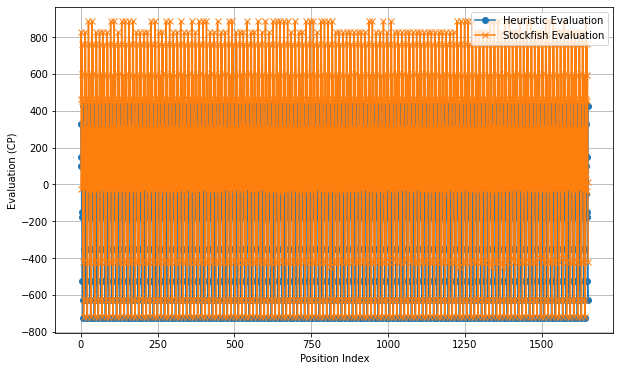

In [ ]:
# Plot the evaluations
plot_output_eval(heuristic_evaluations, stockfish_evaluations)

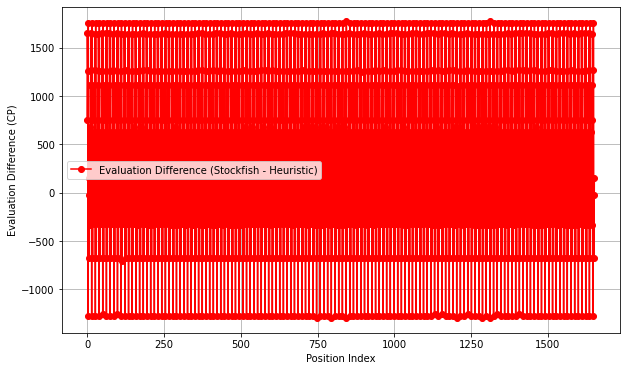

In [ ]:
plot_evaluation_difference(heuristic_evaluations, stockfish_evaluations)

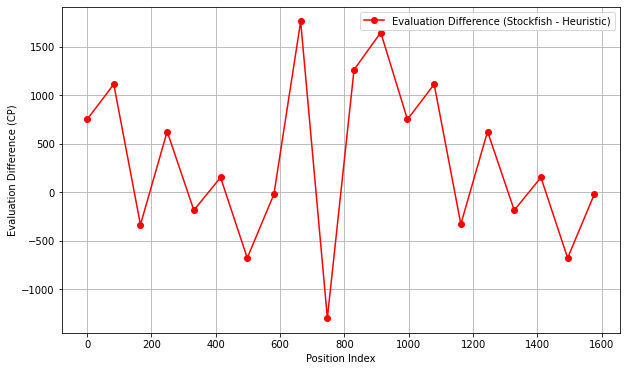

In [ ]:
plot_evaluation_difference_2(heuristic_evaluations, stockfish_evaluations, max_points=20)

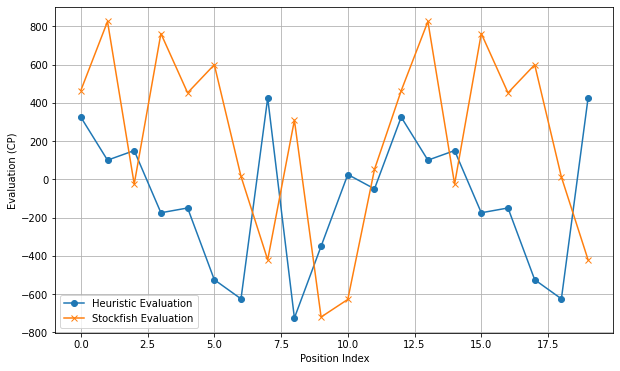

In [ ]:
plot_output_eval_2(heuristic_evaluations, stockfish_evaluations, 20)